In [2]:
import pandas as pd
from scipy import stats
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import datetime
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping,TensorBoard
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
import matplotlib.pyplot as plt


In [3]:
earthquake_data = pd.read_csv('database.csv') #Give the location of dataset here
# First 5 rows of dataset 
earthquake_data.head() 

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [4]:
# Checking for missing values
missing_values = earthquake_data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Date                              0
Time                              0
Latitude                          0
Longitude                         0
Type                              0
Depth                             0
Depth Error                   18951
Depth Seismic Stations        16315
Magnitude                         0
Magnitude Type                    3
Magnitude Error               23085
Magnitude Seismic Stations    20848
Azimuthal Gap                 16113
Horizontal Distance           21808
Horizontal Error              22256
Root Mean Square               6060
ID                                0
Source                            0
Location Source                   0
Magnitude Source                  0
Status                            0
dtype: int64


In [5]:
# Dropping datas with too many missing values since they are now a burden on our dataset
null_columns = earthquake_data.loc[:, earthquake_data.isna().sum() > 0.66 * earthquake_data.shape[0]].columns
earthquake_data = earthquake_data.drop(null_columns, axis=1)
# Handling Magnitude type since it has only 3 datas not available
earthquake_data['Magnitude Type'].fillna(earthquake_data['Magnitude Type'].mode()[0], inplace=True)
earthquake_data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,MW,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,MW,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,MW,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [6]:
earthquake_data['Root Mean Square'] = earthquake_data['Root Mean Square'].fillna(earthquake_data['Root Mean Square'].mean())
earthquake_data = earthquake_data.dropna(axis=0).reset_index(drop=True)

In [7]:
# Checking again for missing values

missing_values = earthquake_data.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
Date                0
Time                0
Latitude            0
Longitude           0
Type                0
Depth               0
Magnitude           0
Magnitude Type      0
Root Mean Square    0
ID                  0
Source              0
Location Source     0
Magnitude Source    0
Status              0
dtype: int64


In [8]:
# Identify outliers in 'magnitude' using z-score
z_scores = stats.zscore(earthquake_data['Magnitude'])
outliers = (z_scores > 6.5) | (z_scores < -6.5)
outlier_count = len(earthquake_data[outliers])
print(earthquake_data[outliers])
print(f"Number of outliers in 'magnitude': {outlier_count}")

             Date      Time  Latitude  Longitude        Type  Depth  \
16     02/04/1965  05:01:22    51.251    178.715  Earthquake   30.3   
17083  12/26/2004  00:58:53     3.295     95.982  Earthquake   30.0   
19928  02/27/2010  06:34:12   -36.122    -72.898  Earthquake   22.9   
20501  03/11/2011  05:46:24    38.297    142.373  Earthquake   29.0   

       Magnitude Magnitude Type  Root Mean Square  \
16           8.7             MW          1.022784   
17083        9.1             MW          1.170000   
19928        8.8            MWW          1.090000   
20501        9.1            MWW          1.160000   

                                 ID    Source Location Source  \
16        OFFICIAL19650204050122_30  OFFICIAL          ISCGEM   
17083  OFFICIAL20041226005853450_30  OFFICIAL              US   
19928  OFFICIAL20100227063411530_30  OFFICIAL              US   
20501  OFFICIAL20110311054624120_30  OFFICIAL              US   

      Magnitude Source     Status  
16            OF

In [9]:
# Cap outliers to a specified threshold
cap_threshold = 6.5
earthquake_data['Magnitude'] = earthquake_data['Magnitude'].apply(lambda x: cap_threshold if x > cap_threshold else x)
# Outliers handled successfully!!!

In [10]:
earthquake_data.head()

,Date,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW,1.022784,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW,1.022784,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.579,-173.972,Earthquake,20.0,6.2,MW,1.022784,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.076,-23.557,Earthquake,15.0,5.8,MW,1.022784,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.938,126.427,Earthquake,15.0,5.8,MW,1.022784,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic


In [11]:
# Summary statistics for numerical columns
print("\nSummary Statistics:")
print(earthquake_data.describe())

# Check data types and missing values
print("\nData Types and Missing Values:")
print(earthquake_data.info())


Summary Statistics:
           Latitude     Longitude         Depth     Magnitude  \
count  23412.000000  23412.000000  23412.000000  23412.000000   
mean       1.679033     39.639961     70.767911      5.845790   
std       30.113183    125.511959    122.651898      0.322132   
min      -77.080000   -179.997000     -1.100000      5.500000   
25%      -18.653000    -76.349750     14.522500      5.600000   
50%       -3.568500    103.982000     33.000000      5.700000   
75%       26.190750    145.026250     54.000000      6.000000   
max       86.005000    179.998000    700.000000      6.500000   

       Root Mean Square  
count      23412.000000  
mean           1.022784  
std            0.162319  
min            0.000000  
25%            0.940000  
50%            1.022784  
75%            1.100000  
max            3.440000  

Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 14 columns):
 #   Column       

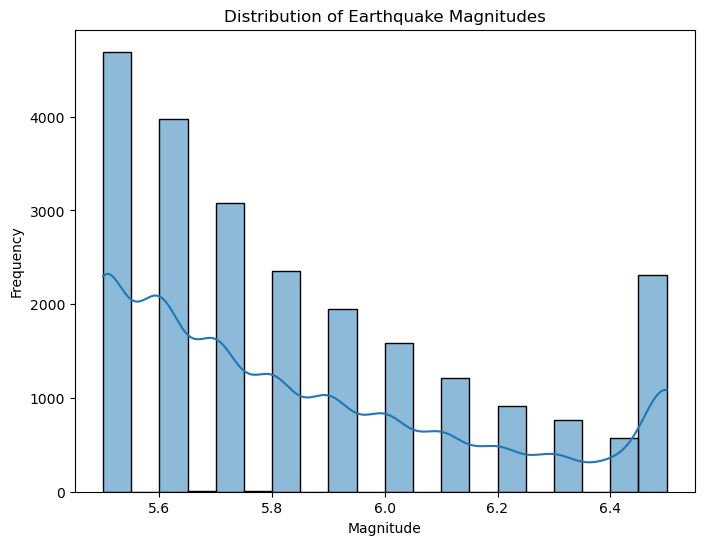

In [12]:
# Explore the distribution of earthquake magnitudes
plt.figure(figsize=(8, 6))
sns.histplot(earthquake_data['Magnitude'], bins=20, kde=True)
plt.title('Distribution of Earthquake Magnitudes')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.show()

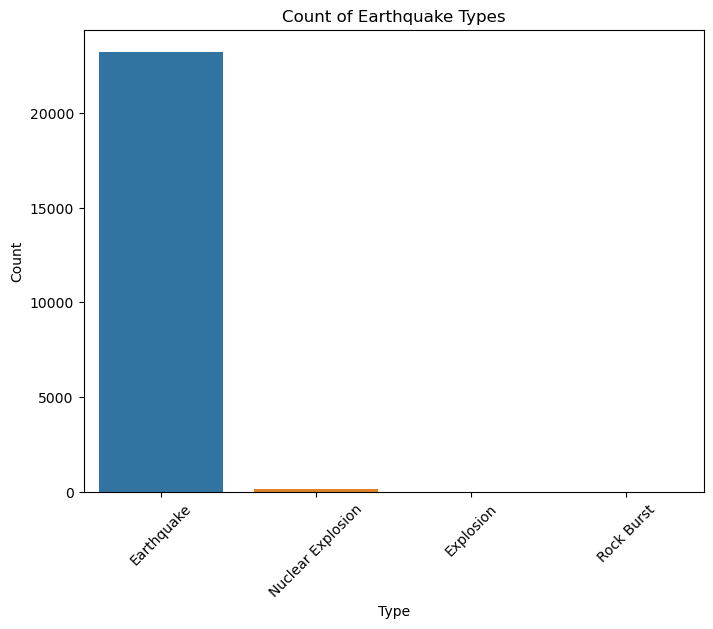

In [14]:
# Explore the count of earthquake types
plt.figure(figsize=(8, 6))
sns.countplot(data=earthquake_data, x='Type')
plt.title('Count of Earthquake Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

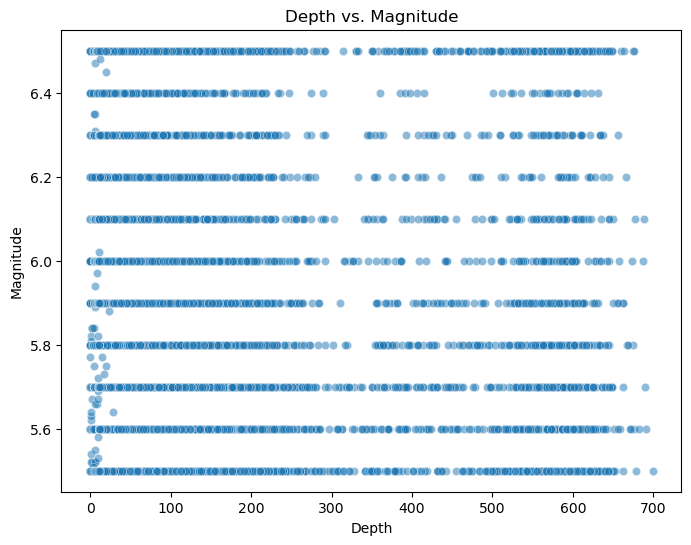

In [15]:
# Explore the relationship between depth and magnitude
plt.figure(figsize=(8, 6))
sns.scatterplot(data=earthquake_data, x='Depth', y='Magnitude', alpha=0.5)
plt.title('Depth vs. Magnitude')
plt.xlabel('Depth')
plt.ylabel('Magnitude')
plt.show()

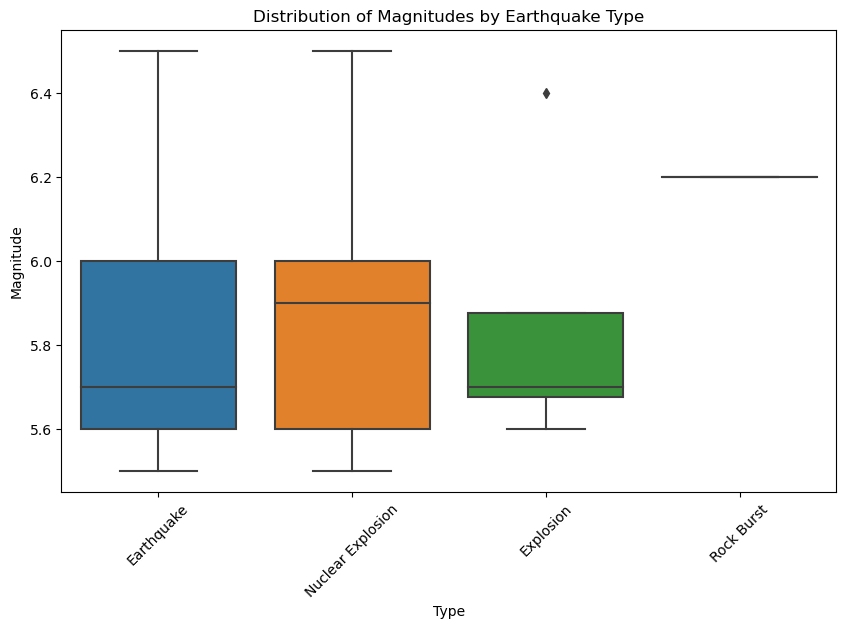

In [16]:
# Explore the distribution of earthquake types by magnitude
plt.figure(figsize=(10, 6))
sns.boxplot(data=earthquake_data, x='Type', y='Magnitude')
plt.title('Distribution of Magnitudes by Earthquake Type')
plt.xlabel('Type')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)
plt.show()

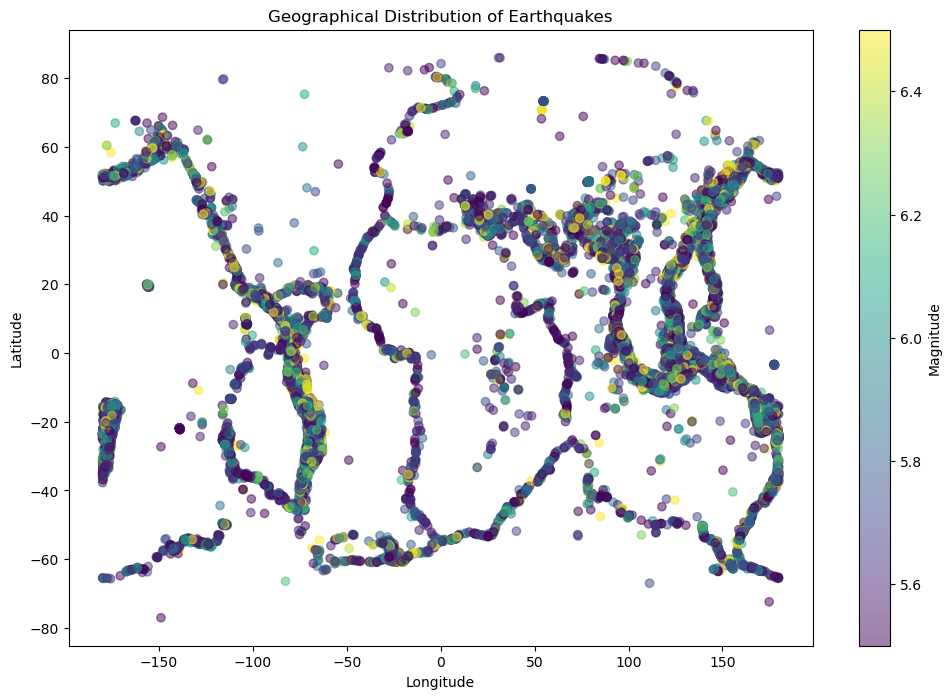

In [17]:
# Explore the geographical distribution of earthquakes using a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(earthquake_data['Longitude'], earthquake_data['Latitude'], c=earthquake_data['Magnitude'], cmap='viridis', alpha=0.5)
plt.title('Geographical Distribution of Earthquakes')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Magnitude')
plt.show()

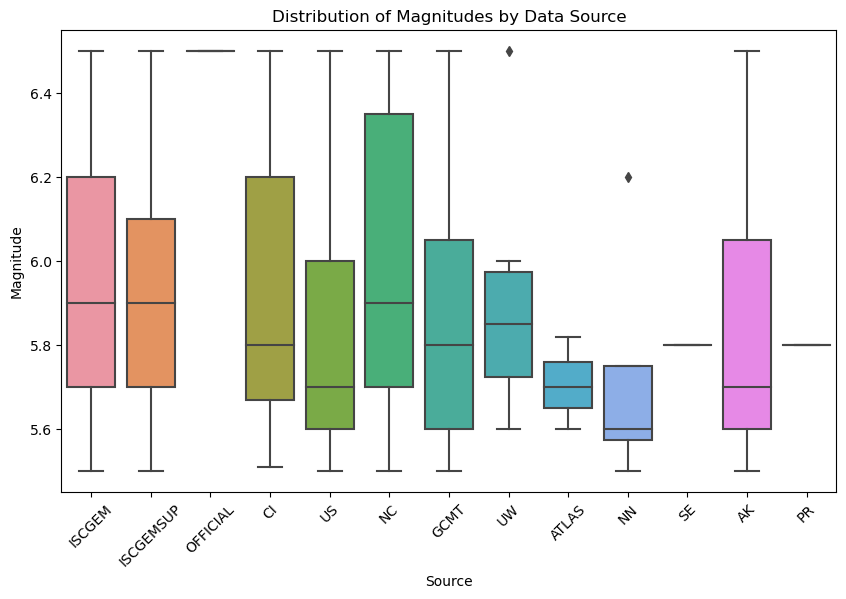

In [18]:
# Explore the distribution of earthquake magnitudes by source
plt.figure(figsize=(10, 6))
sns.boxplot(data=earthquake_data, x='Source', y='Magnitude')
plt.title('Distribution of Magnitudes by Data Source')
plt.xlabel('Source')
plt.ylabel('Magnitude')
plt.xticks(rotation=45)
plt.show()

Summary Statistics for Selected Features:
           Latitude     Longitude         Depth     Magnitude
count  23412.000000  23412.000000  23412.000000  23412.000000
mean       1.679033     39.639961     70.767911      5.845790
std       30.113183    125.511959    122.651898      0.322132
min      -77.080000   -179.997000     -1.100000      5.500000
25%      -18.653000    -76.349750     14.522500      5.600000
50%       -3.568500    103.982000     33.000000      5.700000
75%       26.190750    145.026250     54.000000      6.000000
max       86.005000    179.998000    700.000000      6.500000


C:\Users\ashwi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


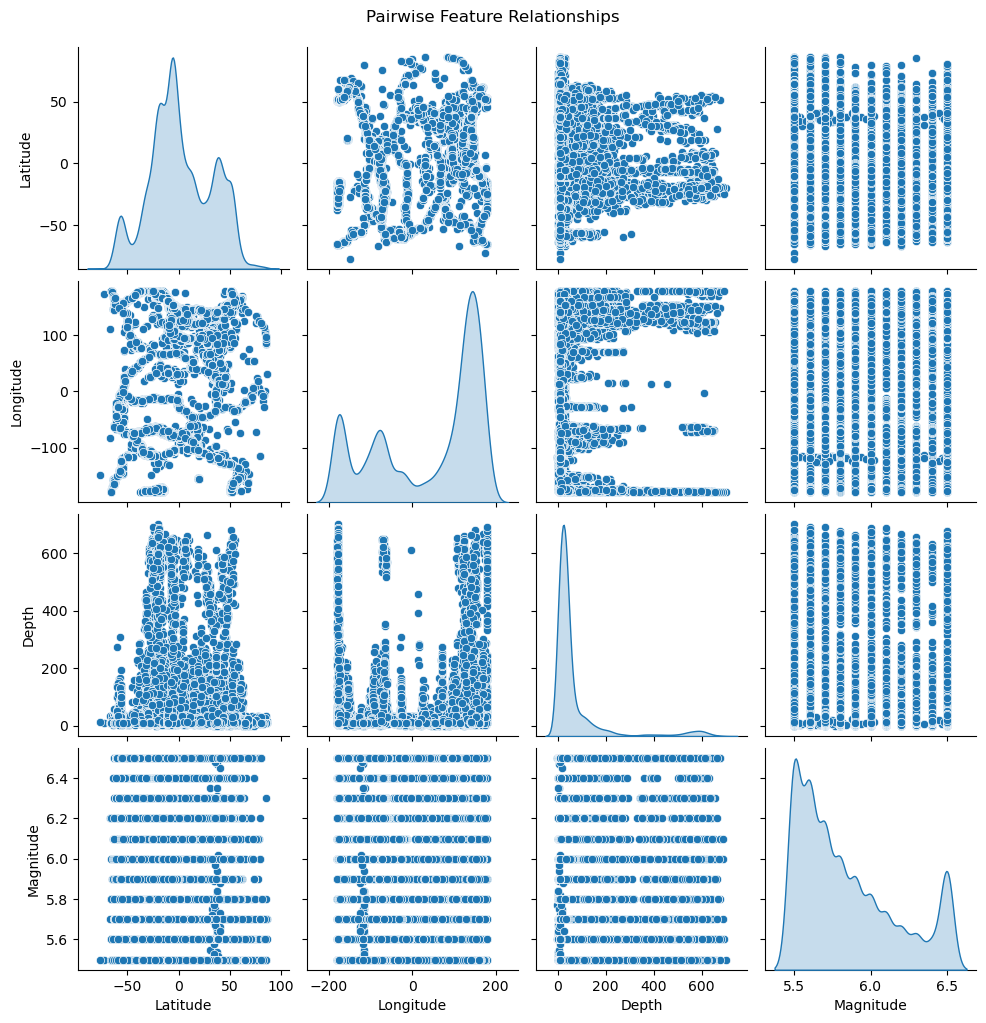

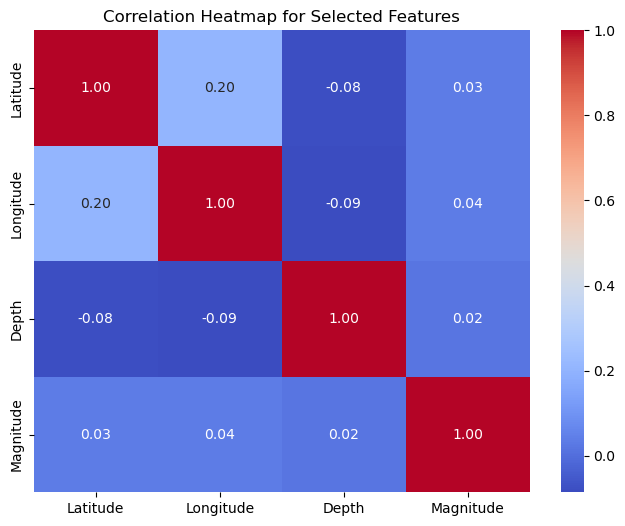

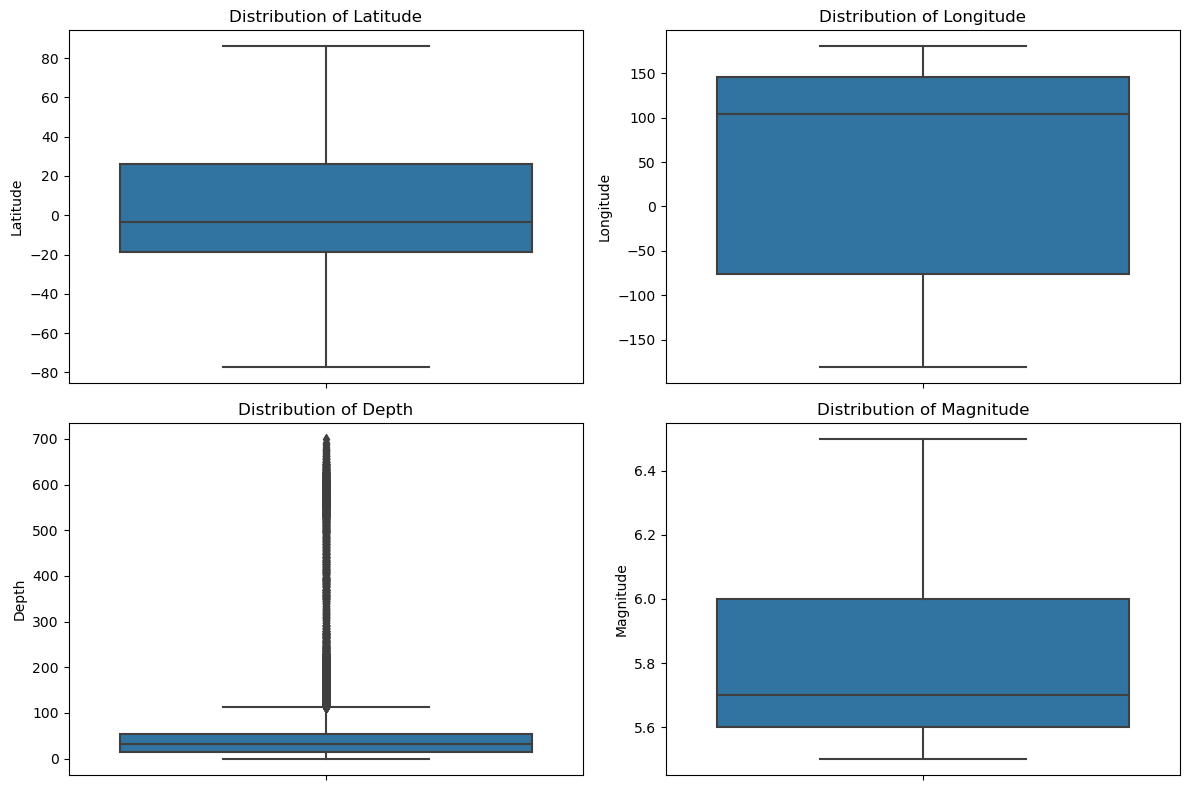

In [19]:
# Select key features for analysis
selected_features = ['Latitude', 'Longitude', 'Depth', 'Magnitude']

# Summary statistics for selected numerical features
selected_summary = earthquake_data[selected_features].describe()
print("Summary Statistics for Selected Features:")
print(selected_summary)

# Pairplot to visualize pairwise feature relationships
sns.pairplot(earthquake_data[selected_features], diag_kind='kde')
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# Correlation heatmap for selected features
correlation_matrix = earthquake_data[selected_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Selected Features')
plt.show()

# Box plots to visualize feature distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(selected_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=earthquake_data, y=feature)
    plt.title(f'Distribution of {feature}')
    plt.ylabel(feature)
plt.tight_layout()
plt.show()

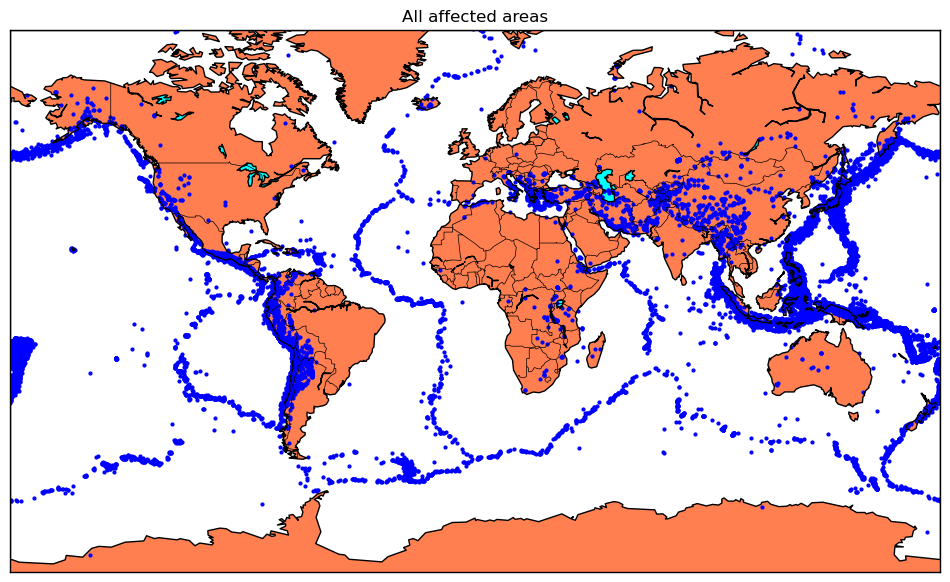

In [20]:
m = Basemap(projection='mill',llcrnrlat=-80,urcrnrlat=80, llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

longitudes = earthquake_data["Longitude"].tolist()
latitudes = earthquake_data["Latitude"].tolist()
x,y = m(longitudes,latitudes)
fig = plt.figure(figsize=(12,10))
plt.title("All affected areas")
m.plot(x, y, "o", markersize = 2, color = 'blue')
m.drawcoastlines()
m.fillcontinents(color='coral',lake_color='aqua')
m.drawmapboundary()
m.drawcountries()
plt.show()

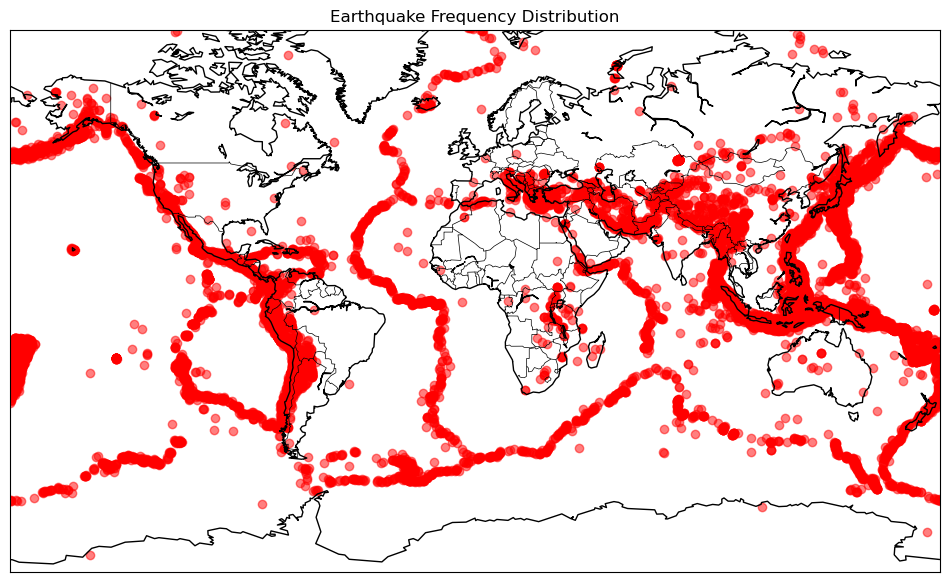

In [21]:
# Create a Basemap object
m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

# Convert latitude and longitude to map coordinates
x, y = m(earthquake_data['Longitude'].values, earthquake_data['Latitude'].values)

# Create a figure and axis for the map
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Plot data points on the map
m.scatter(x, y, marker='o', color='red', alpha=0.5)

# Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries()

plt.title('Earthquake Frequency Distribution')

# Show the map
plt.show()

C:\Users\ashwi\AppData\Local\Temp\ipykernel_10640\1318712618.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin', 'vmax' will be ignored
  sc = ax.scatter(x, y, c='red', alpha=0.5, cmap='hot', vmin=0, vmax=1)  # Set vmin and vmax for consistent color


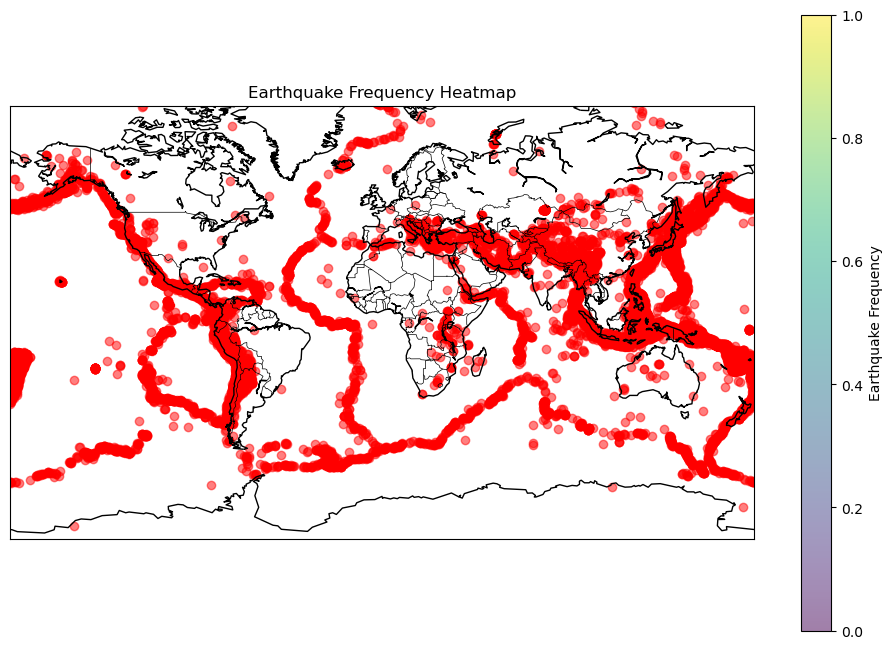

In [22]:
# Create a Basemap object
m = Basemap(projection='mill', llcrnrlat=-80, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')

# Convert latitude and longitude to map coordinates
x, y = m(earthquake_data['Longitude'].values, earthquake_data['Latitude'].values)

# Create a figure and axis for the map
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)

# Plot individual points for each earthquake with a consistent red color
sc = ax.scatter(x, y, c='red', alpha=0.5, cmap='hot', vmin=0, vmax=1)  # Set vmin and vmax for consistent color

# Add a colorbar to indicate earthquake frequency
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label('Earthquake Frequency')

# Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries()

# Add a title
plt.title('Earthquake Frequency Heatmap')

# Show the map
plt.show()

In [23]:
earthquake_data['Month'] = earthquake_data['Date'].apply(lambda x: x[0:2])
earthquake_data['Year'] = earthquake_data['Date'].apply(lambda x: x[-4:])

earthquake_data = earthquake_data.drop('Date', axis=1)

In [25]:
earthquake_data['Month'] = earthquake_data['Month'].astype(np.int32)

In [26]:
earthquake_data[earthquake_data['Year'].str.contains('Z')]

,Time,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Month,Year
3378,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,5.6,MB,1.022784,USP0000A09,US,US,US,Reviewed,19,000Z
7512,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,5.6,MW,1.300000,USP0002E81,US,US,HRV,Reviewed,19,530Z
20650,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,5.8,MWC,1.060000,USP000HWQP,US,US,GCMT,Reviewed,20,520Z


In [27]:
invalid_year_indices = earthquake_data[earthquake_data['Year'].str.contains('Z')].index

earthquake_data = earthquake_data.drop(invalid_year_indices, axis=0).reset_index(drop=True)

In [29]:
earthquake_data['Hour'] = earthquake_data['Time'].apply(lambda x: np.int32(x[0:2]))

earthquake_data = earthquake_data.drop('Time', axis=1)

In [30]:
earthquake_data

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status,Month,Year,Hour
0,19.2460,145.6160,Earthquake,131.60,6.0,MW,1.022784,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic,1,1965,13
1,1.8630,127.3520,Earthquake,80.00,5.8,MW,1.022784,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic,1,1965,11
2,-20.5790,-173.9720,Earthquake,20.00,6.2,MW,1.022784,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic,1,1965,18
3,-59.0760,-23.5570,Earthquake,15.00,5.8,MW,1.022784,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic,1,1965,18
4,11.9380,126.4270,Earthquake,15.00,5.8,MW,1.022784,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic,1,1965,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23404,38.3917,-118.8941,Earthquake,12.30,5.6,ML,0.189800,NN00570710,NN,NN,NN,Reviewed,12,2016,8
23405,38.3777,-118.8957,Earthquake,8.80,5.5,ML,0.218700,NN00570744,NN,NN,NN,Reviewed,12,2016,9
23406,36.9179,140.4262,Earthquake,10.00,5.9,MWW,1.520000,US10007NAF,US,US,US,Reviewed,12,2016,12
23407,-9.0283,118.6639,Earthquake,79.00,6.3,MWW,1.430000,US10007NL0,US,US,US,Reviewed,12,2016,22


In [31]:
earthquake_data['Status'].unique()

array(['Automatic', 'Reviewed'], dtype=object)

In [32]:
earthquake_data['Status'] = earthquake_data['Status'].apply(lambda x: 1 if x == 'Reviewed' else 0)
earthquake_data['Type'].unique()

array(['Earthquake', 'Nuclear Explosion', 'Explosion', 'Rock Burst'],
      dtype=object)

In [33]:
def onehot_encode(df, columns, prefixes):
    df = df.copy()
    for column, prefix in zip(columns, prefixes):
        dummies = pd.get_dummies(df[column], prefix=prefix)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

In [34]:
earthquake_data = onehot_encode(
    earthquake_data,
    ['Type', 'Magnitude Type', 'Source', 'Location Source', 'Magnitude Source'],
    ['t', 'mt', 's', 'ls', 'ms']
)

In [35]:
earthquake_data=earthquake_data.drop('ID',axis=1)

In [36]:
earthquake_data.to_csv('df.csv', index=False)

In [37]:
y = earthquake_data.loc[:, 'Status']
X = earthquake_data.drop('Status', axis=1)

scaler = StandardScaler()

X = scaler.fit_transform(X)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=56)

In [41]:
# Don't run this more than once or if you have the dataset with you
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

In [47]:
X_train.shape


(16386, 107)

In [42]:
best_accuracy=0
best_dense_layer=None 
num_epochs = 30

In [43]:
dense_layers = [0, 1, 2, 3 , 4 , 5]
layer_sizes = [32, 64, 128]

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
            tb = "{}-dense-{}-nodes-{}-time".format(dense_layer, layer_size,  int(time.time()))
            print(tb)

0-dense-32-nodes-1698837076-time
0-dense-64-nodes-1698837076-time
0-dense-128-nodes-1698837076-time
1-dense-32-nodes-1698837076-time
1-dense-64-nodes-1698837076-time
1-dense-128-nodes-1698837076-time
2-dense-32-nodes-1698837076-time
2-dense-64-nodes-1698837076-time
2-dense-128-nodes-1698837076-time
3-dense-32-nodes-1698837076-time
3-dense-64-nodes-1698837076-time
3-dense-128-nodes-1698837076-time
4-dense-32-nodes-1698837076-time
4-dense-64-nodes-1698837076-time
4-dense-128-nodes-1698837076-time
5-dense-32-nodes-1698837076-time
5-dense-64-nodes-1698837076-time
5-dense-128-nodes-1698837076-time


In [62]:
import os
for num_dense_layers in dense_layers:
    for layer_size in layer_sizes:
        tb = f"{num_dense_layers}-dense-{layer_size}-nodes-{int(time.time())}"
        print(tb)
        
        model = Sequential()
        
        # Input layer
        model.add(Dense(64, input_shape=(107,)))
        model.add(Activation('relu'))
        
        # Hidden layers with dropout
        for _ in range(num_dense_layers):
            model.add(Dense(layer_size))
            model.add(Activation('relu'))
            model.add(Dropout(0.3))  # Add a dropout layer with a dropout rate of 0.5 (adjust as needed)
        
        # Output layer
        model.add(Dense(1))
        model.add(Activation('sigmoid'))
        
        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        # Set up the TensorBoard callback
        log_dir = os.path.join("logs", tb)
        tensorboard_callback = TensorBoard(log_dir=log_dir)
        
        # Train the model with the TensorBoard callback
        model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=0, callbacks=[tensorboard_callback])
        
        # Evaluate the model on the test set
        val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        print(f"Number of Dense Layers: {num_dense_layers}, Validation Accuracy: {val_accuracy}")
        
        # Track the best configuration
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_num_dense_layers = num_dense_layers

print(f"Best Number of Dense Layers: {best_num_dense_layers}, Best Validation Accuracy: {best_accuracy}")

0-dense-32-nodes-1698838822
Number of Dense Layers: 0, Validation Accuracy: 0.9991456866264343
0-dense-64-nodes-1698838863
Number of Dense Layers: 0, Validation Accuracy: 0.9990032911300659
0-dense-128-nodes-1698838905
Number of Dense Layers: 0, Validation Accuracy: 0.9990032911300659
1-dense-32-nodes-1698838948
Number of Dense Layers: 1, Validation Accuracy: 1.0
1-dense-64-nodes-1698838998
Number of Dense Layers: 1, Validation Accuracy: 1.0
1-dense-128-nodes-1698839049
Number of Dense Layers: 1, Validation Accuracy: 1.0
2-dense-32-nodes-1698839098
Number of Dense Layers: 2, Validation Accuracy: 1.0
2-dense-64-nodes-1698839153
Number of Dense Layers: 2, Validation Accuracy: 1.0
2-dense-128-nodes-1698839210
Number of Dense Layers: 2, Validation Accuracy: 1.0
3-dense-32-nodes-1698839265
Number of Dense Layers: 3, Validation Accuracy: 1.0
3-dense-64-nodes-1698839327
Number of Dense Layers: 3, Validation Accuracy: 1.0
3-dense-128-nodes-1698839391
Number of Dense Layers: 3, Validation Accur

In [52]:

num_dense_layers = 3
layer_size = 32


model = Sequential()

# Input layer
model.add(Dense(64, input_shape=(107,)))  # Input shape (adjust as needed)
model.add(Activation('relu'))

# Hidden layers with dropout
for _ in range(num_dense_layers):
    model.add(Dense(layer_size))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))  # You can adjust the dropout rate as needed

# Output layer
model.add(Dense(1))
model.add(Activation('sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Set up the TensorBoard callback
log_dir = os.path.join("logs", f"final-{num_dense_layers}-dense-{layer_size}-nodes")
tensorboard_callback = TensorBoard(log_dir=log_dir)

# Train the model with the TensorBoard callback
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, verbose=1, callbacks=[tensorboard_callback])

# Evaluate the model on the test set
val_loss, val_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Number of Dense Layers: {num_dense_layers}, Number of Nodes: {layer_size}, Validation Accuracy: {val_accuracy}")


Epoch 1/30
513/513 [==============================] - 6s 4ms/step - loss: 0.0668 - accuracy: 0.9812
Epoch 2/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0072 - accuracy: 0.9995
Epoch 3/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 4/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 5/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0023 - accuracy: 0.9996
Epoch 6/30
513/513 [==============================] - 2s 4ms/step - loss: 0.0030 - accuracy: 0.9998
Epoch 7/30
513/513 [==============================] - 2s 4ms/step - loss: 4.8010e-04 - accuracy: 0.9998
Epoch 8/30
513/513 [==============================] - 2s 4ms/step - loss: 8.9962e-04 - accuracy: 0.9999
Epoch 9/30
513/513 [==============================] - 2s 4ms/step - loss: 5.1157e-04 - accuracy: 0.9998
Epoch 10/30
513/513 [==============================] - 2s 4ms/step - loss: 4.1723e-04 - 

Epoch 1/30
410/410 [==============================] - 2s 5ms/step - loss: 1.5704e-05 - accuracy: 1.0000 - val_loss: 1.4320e-17 - val_accuracy: 1.0000
Epoch 2/30
410/410 [==============================] - 2s 5ms/step - loss: 9.3171e-05 - accuracy: 1.0000 - val_loss: 6.8766e-18 - val_accuracy: 1.0000
Epoch 3/30
410/410 [==============================] - 2s 5ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 9.7510e-12 - val_accuracy: 1.0000
Epoch 4/30
410/410 [==============================] - 2s 5ms/step - loss: 6.6527e-05 - accuracy: 0.9999 - val_loss: 8.7897e-12 - val_accuracy: 1.0000
Epoch 5/30
410/410 [==============================] - 2s 5ms/step - loss: 6.6436e-07 - accuracy: 1.0000 - val_loss: 9.2345e-12 - val_accuracy: 1.0000
Epoch 6/30
410/410 [==============================] - 2s 5ms/step - loss: 3.1194e-05 - accuracy: 1.0000 - val_loss: 3.9019e-12 - val_accuracy: 1.0000
Epoch 6: early stopping


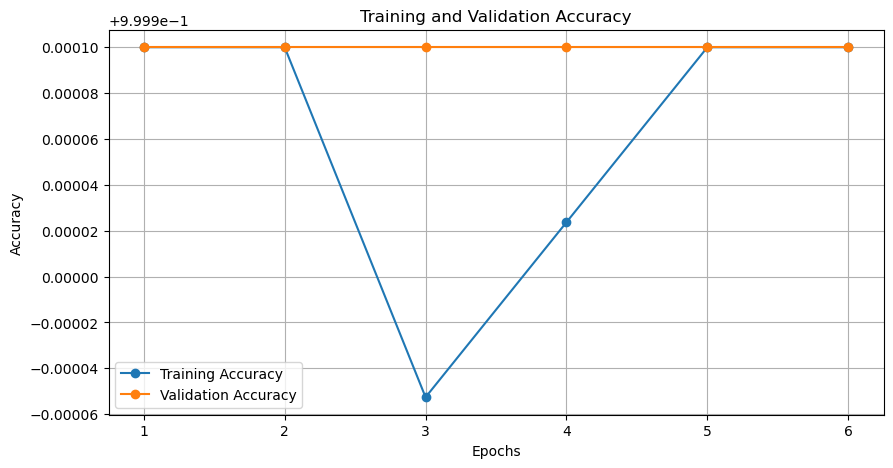

In [54]:
monitor = EarlyStopping(monitor='val_loss', min_delta=7e-6,patience=5, verbose=1, mode='auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=32, epochs=30, callbacks=[monitor])


# Use the actual keys for training and validation accuracy
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_accuracy) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.grid(True)
plt.show()


In [55]:
classifier1 = RandomForestClassifier(n_estimators=50, random_state=1)
classifier2 = RandomForestClassifier(n_estimators=50, random_state=2)
meta_classifier = LogisticRegression()
stacking_classifier = StackingClassifier(
    estimators=[('rf1', classifier1), ('rf2', classifier2)],
    final_estimator=meta_classifier
)
stacking_classifier.fit(X_train, y_train)
stacking_pred = stacking_classifier.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_pred)
print(f'Stacking Accuracy: {stacking_accuracy}')


Stacking Accuracy: 1.0


In [56]:
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)
xgb_classifier.fit(X_train, y_train)
xgb_pred = xgb_classifier.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f'XGBoost Accuracy: {xgb_accuracy}')


XGBoost Accuracy: 1.0


In [57]:
base_classifier = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(base_classifier, n_estimators=50, random_state=56)
adaboost_classifier.fit(X_train, y_train)
adaboost_pred = adaboost_classifier.predict(X_test)
adaboost_accuracy = accuracy_score(y_test, adaboost_pred)
print(f'AdaBoost Accuracy: {adaboost_accuracy}')


AdaBoost Accuracy: 1.0


In [58]:
classifier1 = RandomForestClassifier(n_estimators=50, random_state=1)
classifier2 = RandomForestClassifier(n_estimators=50, random_state=2)
classifier3 = RandomForestClassifier(n_estimators=50, random_state=3)
classifier1.fit(X_train, y_train)
classifier2.fit(X_train, y_train)
classifier3.fit(X_train, y_train)
pred1 = classifier1.predict(X_test)
pred2 = classifier2.predict(X_test)
pred3 = classifier3.predict(X_test)
ensemble_pred = np.round((pred1 + pred2 + pred3) / 3)
randomforest_accuracy = accuracy_score(y_test, ensemble_pred)
print(f'Randomforest Accuracy: {randomforest_accuracy}')


Randomforest Accuracy: 1.0


In [59]:
model1 = DecisionTreeClassifier(random_state=42)
model2 = RandomForestClassifier(random_state=42)
model3 = SVC(probability=True, random_state=42)
voting_model = VotingClassifier(estimators=[('dt', model1), ('rf', model2), ('svc', model3)], voting='soft')
voting_model.fit(X_train, y_train)
predictions = voting_model.predict(X_test)
voting_accuracy = accuracy_score(y_test, predictions)
print(f'voting_accuracy: {voting_accuracy}')

voting_accuracy: 1.0


In [60]:
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, n_estimators=10, random_state=56)
bagging_model.fit(X_train,y_train)
predictions=bagging_model.predict(X_test)
bagging_accuracy=accuracy_score(y_test,predictions)
print(f'bagging_accuracy: {bagging_accuracy}')

bagging_accuracy: 1.0


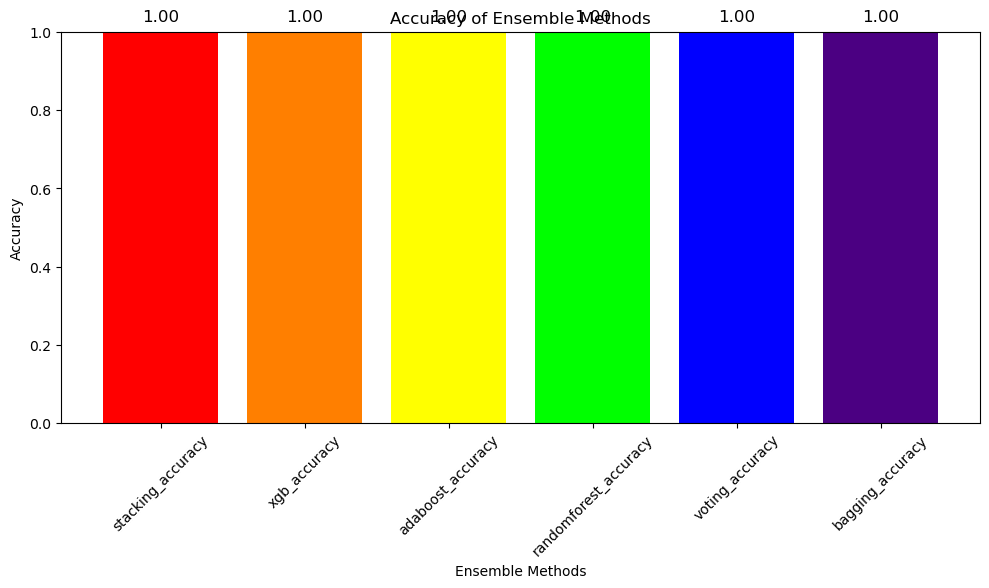

In [61]:
ensemble_methods = ['stacking_accuracy', 'xgb_accuracy', 'adaboost_accuracy', 'randomforest_accuracy', 'voting_accuracy', 'bagging_accuracy']
accuracy_values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

colors = ['#FF0000', '#FF7F00', '#FFFF00', '#00FF00', '#0000FF', '#4B0082']


plt.figure(figsize=(10, 6))
plt.bar(ensemble_methods, accuracy_values, color=colors)
plt.xlabel('Ensemble Methods')
plt.ylabel('Accuracy')
plt.title('Accuracy of Ensemble Methods')
plt.ylim(0, 1)  
plt.xticks(rotation=45)  


for i, acc in enumerate(accuracy_values):
    plt.text(i, acc + 0.02, f'{acc:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()
